# Import Packages

In [35]:
import numpy as np
import tensorflow as tf
tf.config.optimizer.set_jit(True)
tfk = tf.keras
tfkl = tf.keras.layers
tfkltd = tf.keras.layers.TimeDistributed
tfddfts = tf.data.Dataset.from_tensor_slices
from scipy import signal
from scipy.sparse import random

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.decomposition import PCA
plt.rcParams['figure.figsize'] = [15, 2]
plt.rcParams['figure.dpi'] = 144
plt.style.use("ggplot")

import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
print(tf.__version__)

from IPython.display import clear_output

Num GPUs Available:  1
2.9.1


# Set states

In [2]:
s1=signal.windows.bartlett(51)
s2=signal.ricker(200, 10)
s3=signal.windows.bartlett(101)

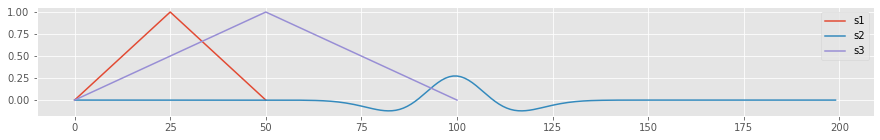

In [3]:
plt.plot(range(len(s1)), s1, label='s1')
plt.plot(range(len(s2)), s2, label='s2')
plt.plot(range(len(s3)), s3, label='s3')
plt.legend()

# Define D

In [4]:
nt = 801 # d or k
nsamp = 10000 # size of D, D is 3*10000

In [5]:
def conv_with_path(s, nsamp, nt, style='sparse'):
    '''
    Returns
    ----------
    d: (nsamp, nt)
    pp: (nsamp, nt)
    '''
    d=np.zeros((nsamp,nt))
    pp=np.zeros((nsamp, nt))
    for i in range(nsamp):
            if style=='spike':
                p=np.random.randn() * signal.unit_impulse(nt,np.random.randint(200,600)) 
            else:
                p=np.array(random(nt, 1, density=0.05).A)[:,0]
            p[0:200] = 0.0
            p[600:nt] = 0.0
            pp[i, :]=p
            d1=signal.convolve(p,s,'same')
            d[i,:]=d1/np.std(d1)
    return d, pp

In [6]:
dsyn1, p1 = conv_with_path(s1, nsamp, nt)
dsyn2, p2 = conv_with_path(s2, nsamp, nt)
dsyn_mix, pmix = conv_with_path(s3, nsamp, nt)
print(dsyn1.shape)
print(dsyn2.shape)
print(dsyn_mix.shape)

(10000, 801)
(10000, 801)
(10000, 801)


8750


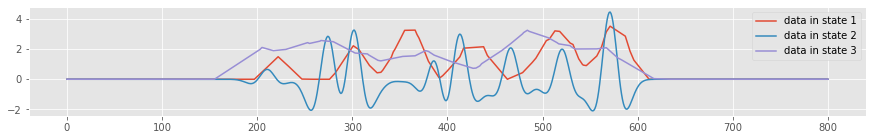

In [7]:
i=np.random.randint(0,nsamp)
plt.plot(dsyn1[i,:], label='data in state 1');
plt.plot(dsyn2[i,:], label='data in state 2');
plt.plot(dsyn_mix[i,:], label='data in state 3');
plt.legend()
print(i)

In [8]:
dsyn1_test, p1test = conv_with_path(s1, 100, nt)
dsyn2_test, p2test = conv_with_path(s2, 100, nt)
dsyn_mix_test, pmix = conv_with_path([1, 0], 100, nt)

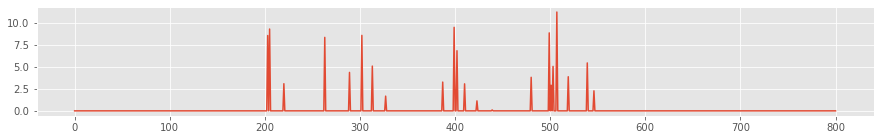

In [9]:
plt.plot(range(801), dsyn_mix_test[0,:])

# Generate X

In [10]:
train_data=[]
train_data.append(dsyn1)
train_data.append(dsyn2)
# train_data.append(dsyn_mix)
test_data=[]
test_data.append(dsyn1_test)
test_data.append(dsyn2_test)
# test_data.append(dsyn_mix_test)
len(train_data)

2

In [11]:
batch_size = 1024
ninstance = 24
weights_train = np.array([ds.shape[0] for ds in train_data]).astype(np.float32)
print(weights_train.shape)

Xo_train_tem = [tfddfts((ds, ds)).repeat().shuffle(500).batch(ninstance, drop_remainder=True) for ds in train_data]
Xo_train = tf.data.Dataset.sample_from_datasets(Xo_train_tem, weights=weights_train).repeat().batch(batch_size)

print(Xo_train.element_spec)
Xo_train = Xo_train.prefetch(tf.data.experimental.AUTOTUNE)

Xo_perf_tem = [tfddfts((ds, ds)).repeat().batch(ninstance, drop_remainder=True) for ds in train_data]
Xo_perf = tf.data.Dataset.sample_from_datasets(Xo_perf_tem, weights=weights_train).repeat().batch(batch_size)

Xo_test_tem = [tfddfts((ds, ds)).repeat().shuffle(ninstance).batch(ninstance, drop_remainder=True) for ds in test_data]
Xo_test = tf.data.Dataset.sample_from_datasets(Xo_test_tem).repeat().batch(batch_size)
print(Xo_test.element_spec)
Xo_test = Xo_test.prefetch(tf.data.experimental.AUTOTUNE)

(2,)


2022-06-30 16:00:51.828320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-30 16:00:52.573682: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13931 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b2:00.0, compute capability: 8.6


(TensorSpec(shape=(None, 24, 801), dtype=tf.float64, name=None), TensorSpec(shape=(None, 24, 801), dtype=tf.float64, name=None))
(TensorSpec(shape=(None, 24, 801), dtype=tf.float64, name=None), TensorSpec(shape=(None, 24, 801), dtype=tf.float64, name=None))


# Set SymAE

In [12]:
class SymAE(tf.keras.Model):
  def __init__(self, nt, nz0, nzi, ninstance):
    super(SymAE, self).__init__()
    self.symencoder=tfk.Sequential(name='symencoder')
    self.symencoder.add(tfkl.Dense(700,activation='elu'))
    self.symencoder.add(tfkl.Dense(600,activation='elu'))
    self.symencoder.add(tfkl.Lambda(lambda x: tf.math.reduce_mean(x, axis=1)))
    self.symencoder.add(tfkl.Dense(500,activation='elu'))
    self.symencoder.add(tfkl.Dense(nz0))
    
    self.nencoder=tfk.Sequential(name='nencoder')
    self.nencoder.add(tfkl.Dense(700,activation='elu'))
    self.nencoder.add(tfkl.Dense(600,activation='elu'))
    self.nencoder.add(tfkl.Dense(512,activation='elu'))
    self.nencoder.add(tfkl.Dense(nzi))
    self.drop=tfkl.Dropout(0.5)
    
    self.decoder=tfk.Sequential(name='decoder')
    self.decoder.add(tfkl.Dense(700,activation='elu'))
    self.decoder.add(tfkl.Dense(800,activation='elu'))
    self.decoder.add(tfkl.Dense(800,activation='elu'))
    self.decoder.add(tfkl.Dense(nt))

    self.repeatzsym=tfk.Sequential()
    self.repeatzsym.add(tfkl.RepeatVector(ninstance))

  def call(self, input_tensor, training=False):
    zsym=self.symencoder(input_tensor)
    zsymr=self.repeatzsym(zsym)

    zn=self.nencoder(input_tensor)
    zn=self.drop(zn, training=training)
    
    lcode=tfkl.concatenate([zsymr, zn], axis=2)
    xhat = self.decoder(lcode)
    return xhat

* First mute the dropout, then try to estimate q such that we have reasolnable data reconsturction
* Then trun dropout on with alpha as 0.5 and the new q is 2* q_old 


In [13]:
nz0 = 100 #p
nzi = 500 #q
model = SymAE(nt, nz0, nzi, ninstance)
model.load_weights('./checkpoint')
model.symencoder.build((None, None, nt))
model.nencoder.build((None, None, nt))
model.decoder.build((None, None, nz0+nzi))

# Train

In [17]:
#model.symencoder.summary()
#model.nencoder.summary()
#model.decoder.summary()
Adam = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-8)
model.compile(optimizer='adam', loss='mse')

In [15]:
pca = PCA(n_components=3)
states = [1]*nsamp + [2]*nsamp + ['mix']*nsamp
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        zi1=model.nencoder(dsyn1)
        zi2=model.nencoder(dsyn2)
        zimix=model.nencoder(dsyn_mix)
        Ns = tf.concat([zi1, zi2, zimix], 0)
        components = pca.fit_transform(Ns)
        fig = px.scatter_3d(components, x=0, y=1, z=2, color=states, title='q space')
        fig.show()

In [91]:
nepoch=20   
history=model.fit(Xo_train, epochs=nepoch, validation_data=Xo_test, 
                  steps_per_epoch=100, validation_steps=1,
                  callbacks=CustomCallback())

100/100 [==============================] - 29s 295ms/step - loss: 0.0176 - val_loss: 0.0087


# Evaluate

Text(0.5, 1.0, 'the p=100 space')

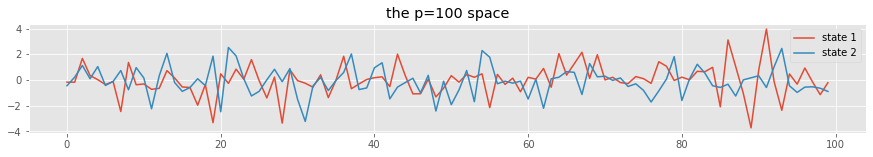

In [23]:
z01=model.symencoder(np.array([dsyn1,]))
z02=model.symencoder(np.array([dsyn2,]))
z0mix=model.symencoder(np.array([dsyn_mix,]))
plt.plot(z01[0], label='state 1')
plt.plot(z02[0], label='state 2')
#plt.plot(z0mix[0])
plt.legend()
plt.title('the p=100 space')

In [24]:
W1 = model.nencoder(dsyn1)
W2 = model.nencoder(dsyn2)
Wmix = model.nencoder(dsyn_mix)

In [25]:
# check reconstruction
Grepeat = np.repeat(z01, len(W1), axis=0)
Z = np.concatenate((Grepeat, W1), axis=1)
dsyn1hat = model.decoder(Z);  # virtual trace

Grepeat = np.repeat(z02, len(W2), axis=0)
Z = np.concatenate((Grepeat, W2), axis=1)
dsyn2hat = model.decoder(Z);  # virtual trace

Grepeat = np.repeat(z0mix, len(Wmix), axis=0)
Z = np.concatenate((Grepeat, Wmix), axis=1)
dsynmixhat = model.decoder(Z);  # virtual trace

In [26]:
# virtual; redatum source 2 to state 1
Grepeat = np.repeat(z02, len(W1), axis=0)
Z = np.concatenate((Grepeat, W1), axis=1)
dsyn21hat = model.decoder(Z)  # virtual trace

Grepeat = np.repeat(z0mix, len(W1), axis=0)
Z = np.concatenate((Grepeat, W1), axis=1)
dsyn1mixhat = model.decoder(Z)  # virtual trace

In [27]:
# virtual; redatum source 1 to state 2
Grepeat = np.repeat(z01, len(W2), axis=0)
Z = np.concatenate((Grepeat, W2), axis=1)
dsyn12hat = model.decoder(Z)  # virtual trace

Grepeat = np.repeat(z0mix, len(W2), axis=0)
Z = np.concatenate((Grepeat, W2), axis=1)
dsyn2mixhat = model.decoder(Z)  # virtual trace

* When we go to state 3; we are supposed 
* States 1 and 2 are the measurements; State 3 is a synthetic state, where we used an impulsive source/
* Redatuming to state 3 means deconvolution --> towards superresolution and resolving
* Assumption are convolutional model. Note that its hard to compress third state. I had to increase q just because of state 3; 

# Plot redatuming

In [63]:
def conv_with_path_redatuming(s, p):
    nsamp, nt = p.shape
    d=np.zeros((nsamp,nt))
    for i in range(nsamp):
            d[i,:] = signal.convolve(p1[i, :], s2, 'same')
            d[i,:] = d[i,:] / np.std(d[i,:])
    return d

In [76]:
dsyn21 = conv_with_path_redatuming(s2, p1)
dsyn12 = conv_with_path_redatuming(s1, p2)

5475


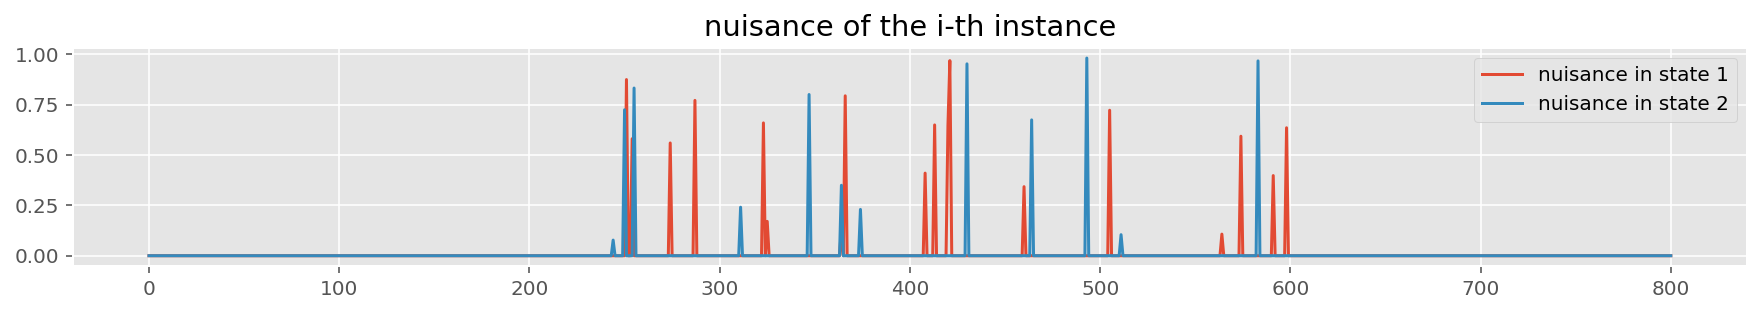

In [83]:
i=np.random.randint(nsamp)
plt.plot(p1[i], label="nuisance in state 1")
plt.plot(p2[i], label="nuisance in state 2")
plt.title('nuisance of the i-th instance')
plt.legend()
print(i)

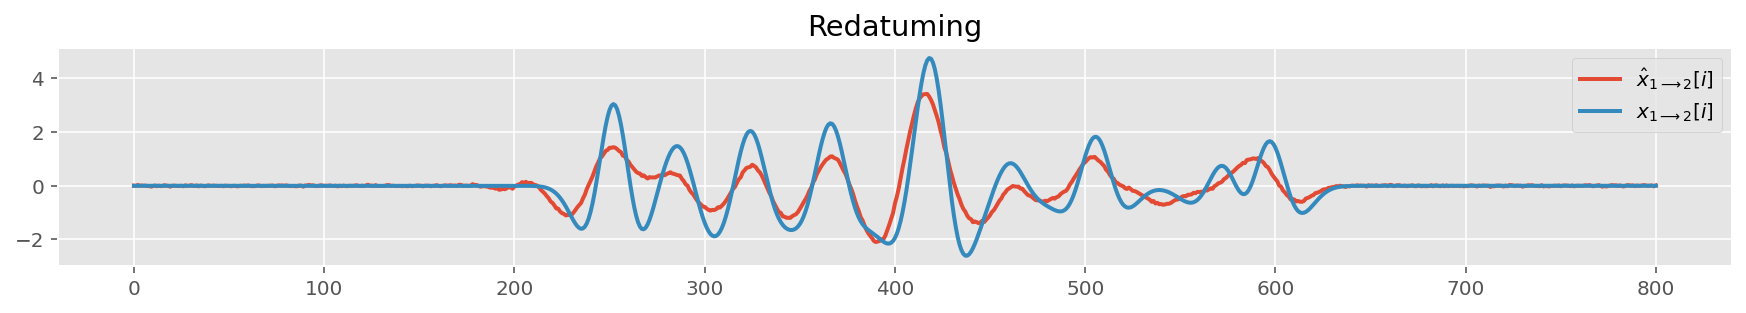

In [87]:
plt.plot(dsyn21hat[i,:], label='$\hat{x}_{1\longrightarrow 2}[i]$', linewidth=2)
plt.plot(dsyn21[i,:], label='$x_{1\longrightarrow 2}[i]$', linewidth=2)
#plt.plot(dsyn1[i,:], label='$x_{1}[i]$', linestyle='dashed', linewidth=4)
plt.title('Redatuming')
plt.legend()

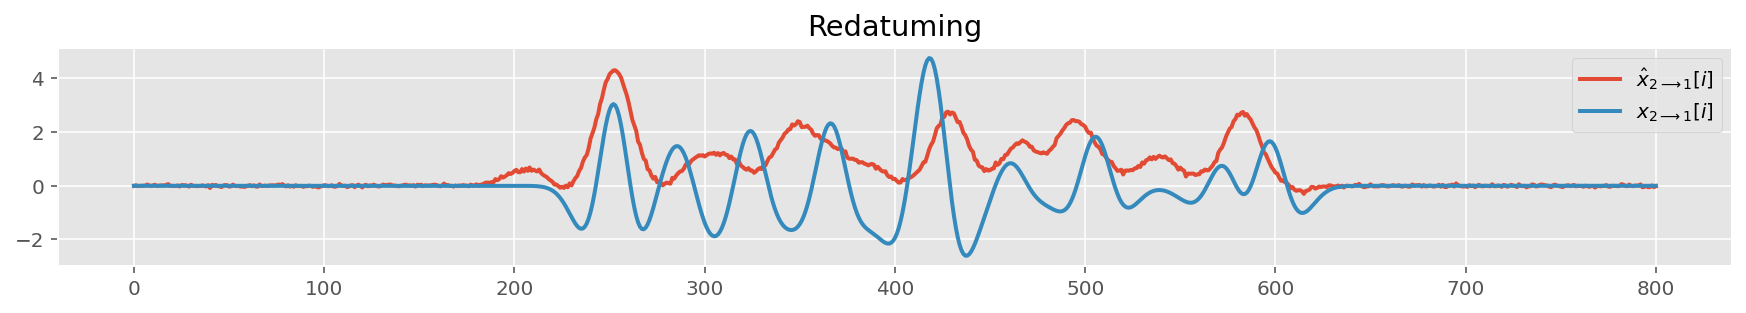

In [88]:
plt.plot(dsyn12hat[i,:], label='$\hat{x}_{2\longrightarrow 1}[i]$', linewidth=2)
plt.plot(dsyn12[i,:], label='$x_{2\longrightarrow 1}[i]$', linewidth=2)
#plt.plot(dsyn2[i,:], label='$x_{2}[i]$', linestyle='dashed', linewidth=4)
plt.title('Redatuming')
plt.legend()

# Plot redatuming (original)

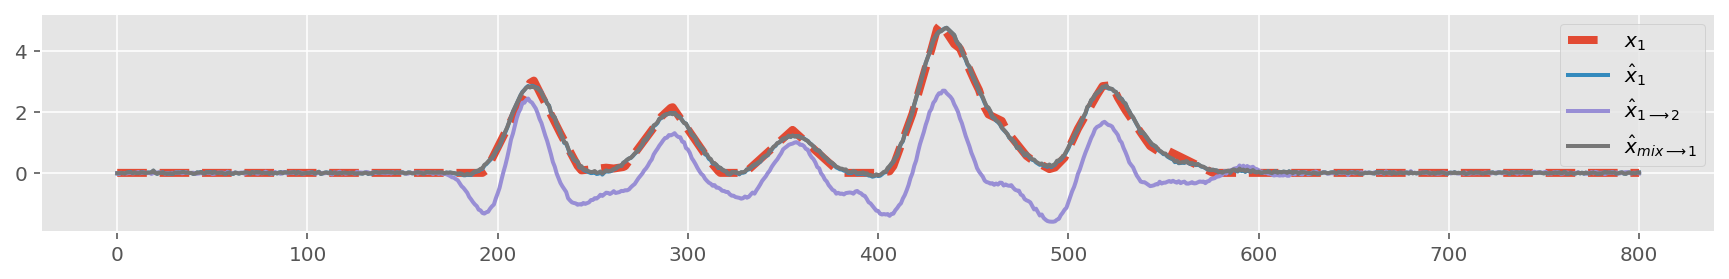

In [46]:
plt.plot(dsyn1[i], label='$x_{1}$', linestyle='dashed', linewidth=4)
plt.plot(dsyn1hat[i], label='$\hat{x}_1$', linewidth=2, )
plt.plot(dsyn21hat[i], label='$\hat{x}_{1\longrightarrow 2}$', linewidth=2  )
plt.plot(dsyn1mixhat[i], label='$\hat{x}_{mix \longrightarrow 1}$', linewidth=2  )
plt.legend()

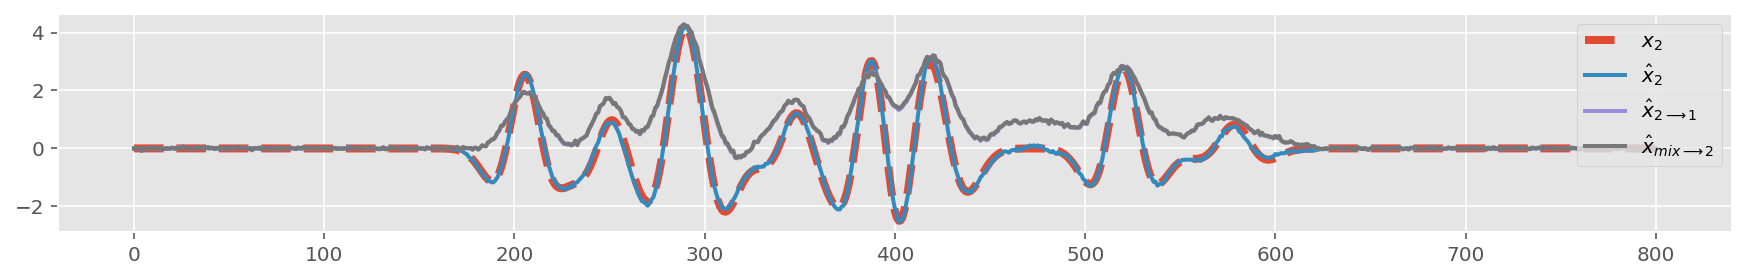

In [40]:
plt.plot(dsyn2[i], label='$x_{2}$', linestyle='dashed', linewidth=4)
plt.plot(dsyn2hat[i], label='$\hat{x}_2$', linewidth=2, )
plt.plot(dsyn12hat[i], label='$\hat{x}_{2\longrightarrow 1}$', linewidth=2  )
plt.plot(dsyn2mixhat[i], label='$\hat{x}_{mix\longrightarrow 2}$', linewidth=2  )
plt.legend()

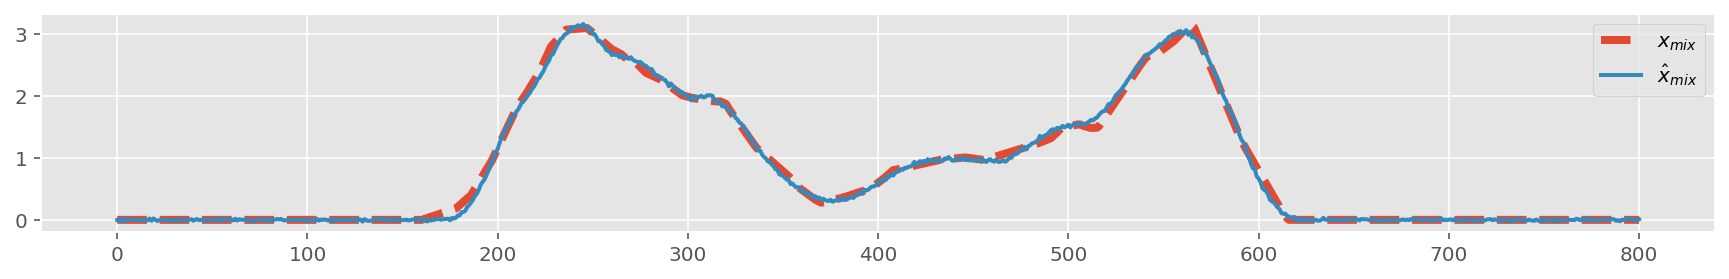

In [45]:
plt.plot(dsyn_mix[i], label='$x_{mix}$', linestyle='dashed', linewidth=4)
plt.plot(dsynmixhat[i], label='$\hat{x}_{mix}$', linewidth=2, )
plt.legend()

# Save weights

In [92]:
#model.save_weights('./checkpoint')